# Predicting MLM messages

In [103]:
import json
import spacy
from spacy.lang.en import English
from spacy.symbols import ORTH
import seaborn as sns 
from matplotlib import pyplot as plt
nlp = spacy.load('en_core_web_sm')

Loading known mlm messages.

In [104]:
mlm_data = open('scheme_message.json','r')
mlm_data = json.load(mlm_data)
mlm_text_data = mlm_data.get('text')
mlm_text_data

['Nice to connect, hoping you and your loved ones are staying safe and well. In addition to networking, and due to the recent economic situation that has taken place, I wanted to reach out. I run an e-commerce-based business that I’m in the process of expanding with like-minded people who are open to building a sustainable, secondary income stream to secure themselves for uncertain times such as where we are today. Without disturbing what you currently do, I wanted to check if you are\xa0open to diversifying part-time through entrepreneurship.\xa0',
 "All is well! These are definitely interesting times and I'm very curious to see how our world will change moving forward.A quick question... Have you ever considered having your own business on the side in addition to your career? I work with a group of successful entrepreneurs who specialize in developing e-commerce businesses that produce passive income. We are looking to partner with entrepreneurial minded and highly ambitious professi

Loading knonw non-mlm messages.

In [105]:
non_mlm_data = open('non_scheme_message.json','r')
non_mlm_data = json.load(non_mlm_data)
non_mlm_text_data = non_mlm_data.get('text')
non_mlm_text_data

['I came across your profile on Clearance Jobs and thought that you may be a good fit for this role. If you were interested in this role that requires the ability to obtain a Top Secret Clearance. This is NOT a contract, this a full time federal GS position. I have included the job description to this message. If you are interested in this role and would like me to submit you to our team please reply back with an updated copy of your updated resume.',
 "Would you be interested in a Contract Analyst opportunity located in Chantilly, VA? This role will be 100% remote due to COVID. The position requires MS Excel, Vlookups, Pivot tables, Data analytics experience and a Bachelor's Degree. Please feel free to contact me if this role may be of interest to you. Have a wonderful day!",
 "I came across your account on LinkedIn and I'd like to follow you.  I enjoy connecting with new people, professionals & colleagues, building a solid network and seeing how we might be able to add value to each 

Creating function to clean text and lemmatize it.

In [106]:
def clean_text(data):
    special_case = [{ORTH: "e-commerce"}]
    nlp.tokenizer.add_special_case("e-commerce", special_case)
    
    clean_data = []
    for text in data:
        text = nlp(text)
        
        temp_data = []
        for word in text:
            if not word.is_stop and not word.is_punct and str(word) != '\xa0':
                if (str(word) == 'entrepreneurial') or (str(word) == 'entrepreneurship'):
                    temp_data.append('entrepreneur')
                else:
                    temp_data.append(str.lower(word.lemma_))
                    
        clean_data.append(temp_data)
        #clean_data.append([str.lower(word.lemma_) for word in text if not word.is_stop and not word.is_punct and str(word) != '\xa0'])
    
    return clean_data

Cleaning text.

In [107]:
mlm_clean_data = clean_text(mlm_text_data)
non_mlm_clean_data = clean_text(non_mlm_text_data)

Creating a single list of data to be counted.

In [108]:
mlm_all_data = [word for data_list in mlm_clean_data for word in data_list]
non_mlm_all_data = [word for data_list in non_mlm_clean_data for word in data_list]

Counting words and sorting the counter from largest to smallests.

In [114]:
non_mlm_counted_data = Counter(non_mlm_all_data)
non_mlm_counted_data = {k: v for k, v in sorted(non_mlm_counted_data.items(), key=lambda item: item[1],reverse= True)}
del non_mlm_counted_data[' ']

In [112]:
mlm_counted_data = Counter(mlm_all_data)
mlm_counted_data = {k: v for k, v in sorted(mlm_counted_data.items(), key=lambda item: item[1],reverse= True)}

Showing amount of unique words and total messages.

In [123]:
print(f'MLM unique words {len(mlm_counted_data.keys())} in {len(mlm_clean_data)} messsages.')
print(f'MLM unique words {len(non_mlm_counted_data.keys())} in {len(non_mlm_clean_data)} messsages.')

MLM unique words 171 in 17 messsages.
MLM unique words 400 in 13 messsages.


Visualizing frequency of top 10 words.

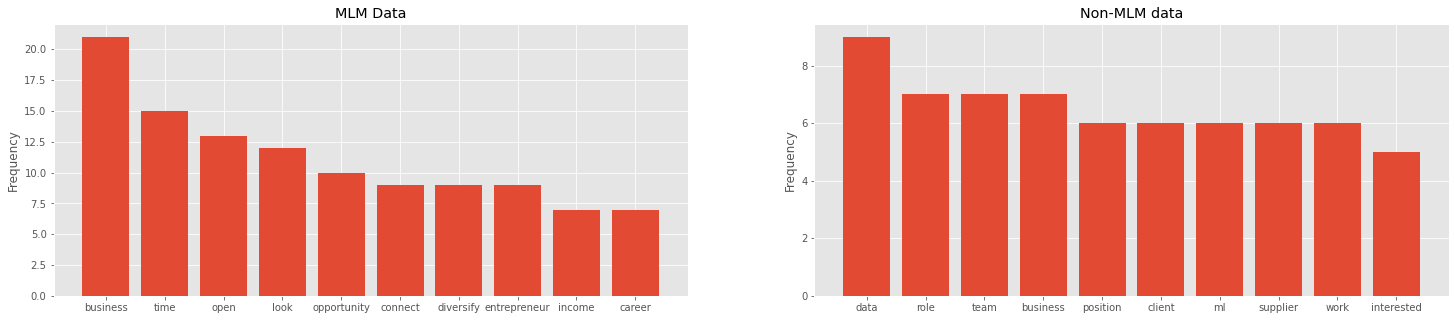

In [128]:
with plt.style.context('ggplot'):
    orderedData = [mlm_counted_data,non_mlm_counted_data]
    titles = ['MLM Data','Non-MLM data']
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
    for col in ax:
        x = list(orderedData[i].keys())[:10]
        y = list(orderedData[i].values())[:10]
        col.bar(x,y)
        col.set_ylabel('Frequency')
        col.set_title(titles[i])
        i += 1

# Modeling 

In [160]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as grid
vectorizer = TfidfVectorizer()
algos = {'Logistic Regression':LogisticRegression(),'Nearest Neighbor':KNeighborsClassifier(),'Naive Bayes':MultinomialNB(),
        'Decision Tree':DecisionTreeClassifier(),'Random Forest':RandomForestClassifier(),'ADA Boost':AdaBoostClassifier(),
        'Gradient Boost':GradientBoostingClassifier(),'SVC':SVC()}

Turning individual clean text to string for vectorization.

In [137]:
mlm_model_data = [' '.join(data) for data in mlm_clean_data]
non_mlm_model_data = [' '.join(data) for data in non_mlm_clean_data]

Turning data into data frame.

In [139]:
mlm_df = pd.DataFrame({'text':mlm_model_data,'class':1})
non_mlm_df = pd.DataFrame({'text':non_mlm_model_data,'class':0})
model_df = pd.concat([mlm_df,non_mlm_df])

Splitting data and target variable.

In [142]:
model_text = model_df.text
model_target = model_df['class']

Vectorizing data.

In [143]:
vectorized_text = vectorizer.fit_transform(model_text)

Extracting order of features.

In [150]:
feature_order = vectorizer.get_feature_names()

Splitting data into test-train.

In [151]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_text,model_target)

Creating function to compare different models.

In [153]:
def ModelCompare(algos,X_train,y_train,X_test,y_test):
    """
    Parameters:
        algos: Dictionary of all algorithms from sklearn to fit
        X_train: X training data
        y_train: y training data
        X_test: X testing data
        y_test: y testing data
    returns:
        data frame with training and testing accuracy scores and f1 scores
    """
    algo = []
    trainAccuracy = []
    testAccuracy = []
    f1Test = []

    for i in algos.keys():
        algo.append(i)
        model = algos.get(i)
        model.fit(X_train,y_train)

        train = model.predict(X_train)
        test = model.predict(X_test)

        trainAccuracy.append(accuracy_score(y_train,train))
        testAccuracy.append(accuracy_score(y_test,test))

        f1Test.append(f1_score(y_test,test))
        
    return pd.DataFrame({'Models':algo,'Training Accuracy':trainAccuracy,'Test Accuracy':testAccuracy,'F1 Test':f1Test})

Comparing models.

In [161]:
model_comparison = ModelCompare(algos,X_train,y_train,X_test,y_test)
model_comparison

,Models,Training Accuracy,Test Accuracy,F1 Test
0,Logistic Regression,1.000000,0.875,0.909091
1,Nearest Neighbor,0.863636,1.000,1.000000
2,Naive Bayes,1.000000,0.875,0.923077
3,Decision Tree,1.000000,0.875,0.909091
4,Random Forest,1.000000,0.750,0.857143
5,ADA Boost,1.000000,0.625,0.769231
6,Gradient Boost,1.000000,0.750,0.800000
7,SVC,1.000000,0.875,0.909091


Training best model.

In [168]:
model = MultinomialNB()
model.fit(vectorized_text,model_target)

MultinomialNB()

Saving best model and saving feature order.

In [169]:
#import pickle
#pickle.dump(model, open('mlm_model.sv', 'wb'))

In [170]:
#pickle.dump(feature_order, open('features.pkl', 'wb'))